# lib

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from collections import deque
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, ConvLSTM1D, Conv1D, Concatenate, Bidirectional
from tensorflow.keras.layers import LSTM , BatchNormalization, AveragePooling1D, Flatten, GRU, SimpleRNN
from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas_ta as ta
plt.style.use('seaborn-darkgrid')

# preprocessing data

In [86]:
path_to_file = "btc.csv"

In [87]:
btc = pd.read_csv(path_to_file, skiprows=1)
btc = btc[::-1]
# btc = btc[2100:]
btc = btc.astype({'date': 'datetime64'}).set_index('date')
btc = btc.drop(['unix', 'symbol','Volume USD'], axis=1)

btc.head()

,open,high,low,close,Volume BTC
date,,,,,
2014-11-28,363.59,381.34,360.57,376.28,3220878.18
2014-11-29,376.42,386.60,372.25,376.72,2746157.05
2014-11-30,376.57,381.99,373.32,373.34,1145566.61
2014-12-01,376.40,382.31,373.03,378.39,2520662.37
2014-12-02,378.39,382.86,375.23,379.25,2593576.46


In [88]:

scleR = btc.values[0]
btc = btc/btc.values[0] - 1
btc.tail()

,open,high,low,close,Volume BTC
date,,,,,
2022-05-10,81.693363,84.619133,81.455640,81.385378,-0.997702
2022-05-11,84.267114,83.303115,75.983027,76.070267,-0.996529
2022-05-12,78.760142,77.907799,69.446931,75.794382,-0.994853
2022-05-13,78.575043,80.225678,78.558394,76.704927,-0.998134
2022-05-14,79.418631,76.509545,79.894279,77.152280,-0.999969


<AxesSubplot:title={'center':'Bitcoin Price'}, xlabel='date'>

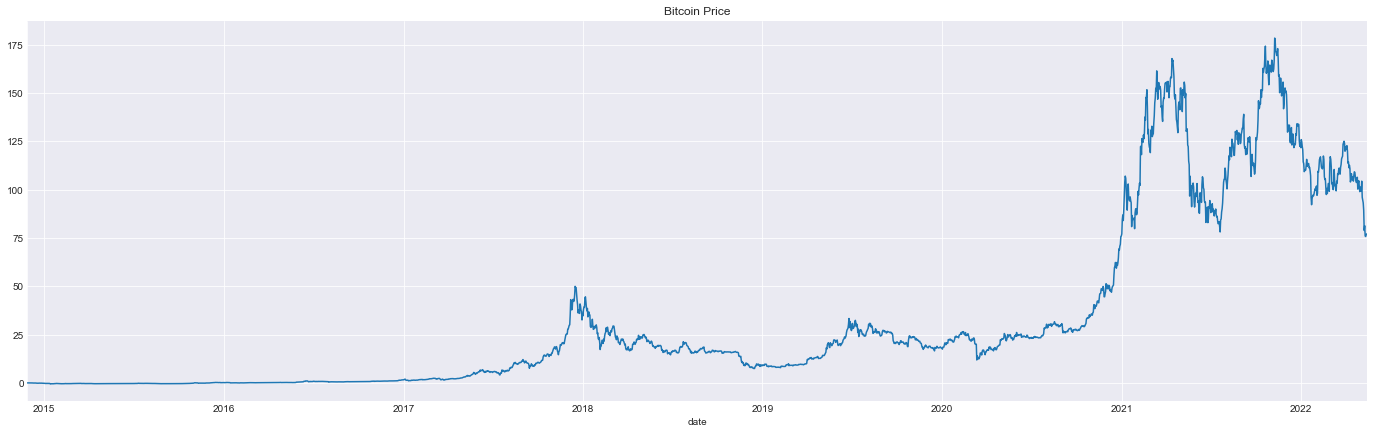

In [89]:
btc.close.plot(figsize=(24,7), title="Bitcoin Price")

In [90]:
btc['target'] = btc['close'].shift(-1)
btc = btc.dropna()

In [91]:
btc.tail()

,open,high,low,close,Volume BTC,target
date,,,,,,
2022-05-09,92.652741,88.747601,82.243198,78.945785,-0.997631,81.385378
2022-05-10,81.693363,84.619133,81.455640,81.385378,-0.997702,76.070267
2022-05-11,84.267114,83.303115,75.983027,76.070267,-0.996529,75.794382
2022-05-12,78.760142,77.907799,69.446931,75.794382,-0.994853,76.704927
2022-05-13,78.575043,80.225678,78.558394,76.704927,-0.998134,77.152280


# creat data lstm

In [92]:
prediction_days = 60

df_train_= btc[:][:len(btc)-prediction_days]#values.reshape(-1,1)

df_test_= btc[:][len(btc)-prediction_days:]#.values.reshape(-1,1)

In [93]:
df_train_.columns

Index(['open', 'high', 'low', 'close', 'Volume BTC', 'target'], dtype='object')

In [94]:
def scl(df):
    q = df[0]
    dq = []
    for i in range(len(df)):
        dq.append(q)
    df = (np.array(df) / np.array(dq)) - 1
    return df, q

In [95]:
# many to one

look_back_ = 30

def dataset_generator_lstm(dataset, look_back=look_back_):
    sequential_data = [] 
    prev_days = deque(maxlen=look_back)
    for i in dataset.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == look_back:  
#             prev_days_, q = scl(prev_days)
            target = i[-1] / prev_days[0][3]
            sequential_data.append([np.array(prev_days), target])
    dataX=[]
    dataY=[]
    for seq, target in sequential_data: 
        dataX.append(seq) 
        dataY.append(target) 
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(df_train_)
trainX, trainY = trainX[2100:], trainY[2100:]
testX, testY = dataset_generator_lstm(df_test_)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testY: ", testX.shape)
print("testY", testY.shape)

trainX:  (535, 30, 5)
trainY:  (535,)
testY:  (31, 30, 5)
testY (31,)


# train

In [74]:
# model = Sequential()

# model.add(LSTM(units = 256,return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 128))
# model.add(Dropout(0.2))

# model.add(Dense(units = 64, activation="relu"))

# model.add(Dense(units = 1))




input_ = Input(shape = (trainX.shape[1], trainX.shape[2]))

rnn11 = Bidirectional(layer=LSTM(units = 256, return_sequences=True))(input_)
drop1 = Dropout(rate=0.2)(rnn11)

rnn12 = Bidirectional(LSTM(units = 128))(drop1)

dense1 = Dense(units = 128, activation="relu")(rnn12)
drop2 = Dropout(rate=0.2)(dense1)

dense2 = Dense(units = 64, activation="relu")(drop2)
drop3 = Dropout(rate=0.2)(dense2)

output = Dense(units = 1)(drop3)

model = Model(inputs=input_, outputs=output)



model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 30, 5)]           0         
                                                                 
 bidirectional_24 (Bidirecti  (None, 30, 512)          536576    
 onal)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 30, 512)           0         
                                                                 
 bidirectional_25 (Bidirecti  (None, 256)              656384    
 onal)                                                           
                                                                 
 dense_38 (Dense)            (None, 128)               32896     
                                                                 
 dropout_29 (Dropout)        (None, 128)               0  

In [75]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01) , loss = 'mean_squared_error')

In [76]:
batch_size = 1024

earlystopping = EarlyStopping(monitor='loss', patience=200, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='loss', patience=30, factor=0.5, min_lr=0.000001)
checkpoint_full = ModelCheckpoint(filepath='my_best_model_v010.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks = [checkpoint_full, earlystopping, rlrop]

In [77]:
# model = load_model('my_best_model_v010.hdf5')

In [78]:
history = model.fit(trainX, trainY, epochs = 300000, batch_size = batch_size, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)


Epoch 1/300000
1/1 [==============================] - ETA: 0s - loss: 1.7244
Epoch 1: loss improved from inf to 1.72437, saving model to my_best_model_v010.hdf5
1/1 [==============================] - 8s 8s/step - loss: 1.7244 - val_loss: 0.1389 - lr: 0.0100
Epoch 2/300000
1/1 [==============================] - ETA: 0s - loss: 0.1694
Epoch 2: loss improved from 1.72437 to 0.16945, saving model to my_best_model_v010.hdf5
1/1 [==============================] - 1s 1s/step - loss: 0.1694 - val_loss: 0.0471 - lr: 0.0100
Epoch 3/300000
1/1 [==============================] - ETA: 0s - loss: 0.1505
Epoch 3: loss improved from 0.16945 to 0.15054, saving model to my_best_model_v010.hdf5
1/1 [==============================] - 1s 1s/step - loss: 0.1505 - val_loss: 0.1096 - lr: 0.0100
Epoch 4/300000
1/1 [==============================] - ETA: 0s - loss: 0.1415
Epoch 4: loss improved from 0.15054 to 0.14146, saving model to my_best_model_v010.hdf5
1/1 [==============================] - 2s 2s/step - l

1/1 [==============================] - 1s 1s/step - loss: 0.1079 - val_loss: 0.1025 - lr: 0.0100
Epoch 36/300000
1/1 [==============================] - ETA: 0s - loss: 0.1113
Epoch 36: loss did not improve from 0.09732
1/1 [==============================] - 2s 2s/step - loss: 0.1113 - val_loss: 0.0211 - lr: 0.0100
Epoch 37/300000
1/1 [==============================] - ETA: 0s - loss: 0.1054
Epoch 37: loss did not improve from 0.09732
1/1 [==============================] - 1s 1s/step - loss: 0.1054 - val_loss: 0.0602 - lr: 0.0100
Epoch 38/300000
1/1 [==============================] - ETA: 0s - loss: 0.1070
Epoch 38: loss did not improve from 0.09732
1/1 [==============================] - 1s 1s/step - loss: 0.1070 - val_loss: 0.0282 - lr: 0.0100
Epoch 39/300000
1/1 [==============================] - ETA: 0s - loss: 0.1004
Epoch 39: loss did not improve from 0.09732
1/1 [==============================] - 2s 2s/step - loss: 0.1004 - val_loss: 0.0449 - lr: 0.0100
Epoch 40/300000
1/1 [======

1/1 [==============================] - 2s 2s/step - loss: 0.0752 - val_loss: 0.0467 - lr: 0.0100
Epoch 108/300000
1/1 [==============================] - ETA: 0s - loss: 0.0859
Epoch 108: loss did not improve from 0.07410
1/1 [==============================] - 1s 1s/step - loss: 0.0859 - val_loss: 0.0224 - lr: 0.0100
Epoch 109/300000
1/1 [==============================] - ETA: 0s - loss: 0.0882
Epoch 109: loss did not improve from 0.07410
1/1 [==============================] - 2s 2s/step - loss: 0.0882 - val_loss: 0.0682 - lr: 0.0100
Epoch 110/300000
1/1 [==============================] - ETA: 0s - loss: 0.0737
Epoch 110: loss improved from 0.07410 to 0.07372, saving model to my_best_model_v010.hdf5
1/1 [==============================] - 2s 2s/step - loss: 0.0737 - val_loss: 0.0205 - lr: 0.0100
Epoch 111/300000
1/1 [==============================] - ETA: 0s - loss: 0.0875
Epoch 111: loss did not improve from 0.07372
1/1 [==============================] - 2s 2s/step - loss: 0.0875 - val_

Epoch 144/300000
1/1 [==============================] - ETA: 0s - loss: 0.0732
Epoch 144: loss did not improve from 0.06898
1/1 [==============================] - 1s 1s/step - loss: 0.0732 - val_loss: 0.0564 - lr: 0.0100
Epoch 145/300000
1/1 [==============================] - ETA: 0s - loss: 0.0722
Epoch 145: loss did not improve from 0.06898
1/1 [==============================] - 2s 2s/step - loss: 0.0722 - val_loss: 0.0153 - lr: 0.0100
Epoch 146/300000
1/1 [==============================] - ETA: 0s - loss: 0.0740
Epoch 146: loss did not improve from 0.06898
1/1 [==============================] - 1s 1s/step - loss: 0.0740 - val_loss: 0.0732 - lr: 0.0100
Epoch 147/300000
1/1 [==============================] - ETA: 0s - loss: 0.0803
Epoch 147: loss did not improve from 0.06898
1/1 [==============================] - 1s 1s/step - loss: 0.0803 - val_loss: 0.0100 - lr: 0.0100
Epoch 148/300000
1/1 [==============================] - ETA: 0s - loss: 0.0726
Epoch 148: loss did not improve from 

Epoch 217/300000
1/1 [==============================] - ETA: 0s - loss: 0.0841
Epoch 217: loss did not improve from 0.05622
1/1 [==============================] - 1s 1s/step - loss: 0.0841 - val_loss: 0.0827 - lr: 0.0100
Epoch 218/300000
1/1 [==============================] - ETA: 0s - loss: 0.0710
Epoch 218: loss did not improve from 0.05622
1/1 [==============================] - 2s 2s/step - loss: 0.0710 - val_loss: 0.0085 - lr: 0.0100
Epoch 219/300000
1/1 [==============================] - ETA: 0s - loss: 0.0724
Epoch 219: loss did not improve from 0.05622
1/1 [==============================] - 2s 2s/step - loss: 0.0724 - val_loss: 0.0506 - lr: 0.0100
Epoch 220/300000
1/1 [==============================] - ETA: 0s - loss: 0.0627
Epoch 220: loss did not improve from 0.05622
1/1 [==============================] - 1s 1s/step - loss: 0.0627 - val_loss: 0.0208 - lr: 0.0100
Epoch 221/300000
1/1 [==============================] - ETA: 0s - loss: 0.0644
Epoch 221: loss did not improve from 

Epoch 254/300000
1/1 [==============================] - ETA: 0s - loss: 0.0604
Epoch 254: loss did not improve from 0.04925
1/1 [==============================] - 2s 2s/step - loss: 0.0604 - val_loss: 0.0456 - lr: 0.0050
Epoch 255/300000
1/1 [==============================] - ETA: 0s - loss: 0.0659
Epoch 255: loss did not improve from 0.04925
1/1 [==============================] - 1s 1s/step - loss: 0.0659 - val_loss: 0.0167 - lr: 0.0050
Epoch 256/300000
1/1 [==============================] - ETA: 0s - loss: 0.0510
Epoch 256: loss did not improve from 0.04925
1/1 [==============================] - 2s 2s/step - loss: 0.0510 - val_loss: 0.0355 - lr: 0.0050
Epoch 257/300000
1/1 [==============================] - ETA: 0s - loss: 0.0546
Epoch 257: loss did not improve from 0.04925
1/1 [==============================] - 2s 2s/step - loss: 0.0546 - val_loss: 0.0322 - lr: 0.0050
Epoch 258/300000
1/1 [==============================] - ETA: 0s - loss: 0.0570
Epoch 258: loss did not improve from 

Epoch 291/300000
1/1 [==============================] - ETA: 0s - loss: 0.0572
Epoch 291: loss did not improve from 0.04925
1/1 [==============================] - 11s 11s/step - loss: 0.0572 - val_loss: 0.0253 - lr: 0.0012
Epoch 292/300000
1/1 [==============================] - ETA: 0s - loss: 0.0591
Epoch 292: loss did not improve from 0.04925
1/1 [==============================] - 12s 12s/step - loss: 0.0591 - val_loss: 0.0232 - lr: 0.0012
Epoch 293/300000
1/1 [==============================] - ETA: 0s - loss: 0.0531
Epoch 293: loss did not improve from 0.04925
1/1 [==============================] - 10s 10s/step - loss: 0.0531 - val_loss: 0.0260 - lr: 0.0012
Epoch 294/300000
1/1 [==============================] - ETA: 0s - loss: 0.0606
Epoch 294: loss did not improve from 0.04925
1/1 [==============================] - 11s 11s/step - loss: 0.0606 - val_loss: 0.0243 - lr: 0.0012
Epoch 295/300000
1/1 [==============================] - ETA: 0s - loss: 0.0564
Epoch 295: loss did not impro

Epoch 328/300000
1/1 [==============================] - ETA: 0s - loss: 0.0594
Epoch 328: loss did not improve from 0.04925
1/1 [==============================] - 12s 12s/step - loss: 0.0594 - val_loss: 0.0246 - lr: 6.2500e-04
Epoch 329/300000
1/1 [==============================] - ETA: 0s - loss: 0.0581
Epoch 329: loss did not improve from 0.04925
1/1 [==============================] - 12s 12s/step - loss: 0.0581 - val_loss: 0.0239 - lr: 6.2500e-04
Epoch 330/300000
1/1 [==============================] - ETA: 0s - loss: 0.0585
Epoch 330: loss did not improve from 0.04925
1/1 [==============================] - 11s 11s/step - loss: 0.0585 - val_loss: 0.0239 - lr: 6.2500e-04
Epoch 331/300000
1/1 [==============================] - ETA: 0s - loss: 0.0549
Epoch 331: loss did not improve from 0.04925
1/1 [==============================] - 11s 11s/step - loss: 0.0549 - val_loss: 0.0224 - lr: 6.2500e-04
Epoch 332/300000
1/1 [==============================] - ETA: 0s - loss: 0.0605
Epoch 332: lo

1/1 [==============================] - ETA: 0s - loss: 0.0539
Epoch 400: loss did not improve from 0.04871
1/1 [==============================] - 10s 10s/step - loss: 0.0539 - val_loss: 0.0243 - lr: 1.5625e-04
Epoch 401/300000
1/1 [==============================] - ETA: 0s - loss: 0.0547
Epoch 401: loss did not improve from 0.04871
1/1 [==============================] - 10s 10s/step - loss: 0.0547 - val_loss: 0.0239 - lr: 1.5625e-04
Epoch 402/300000
1/1 [==============================] - ETA: 0s - loss: 0.0547
Epoch 402: loss did not improve from 0.04871
1/1 [==============================] - 10s 10s/step - loss: 0.0547 - val_loss: 0.0240 - lr: 1.5625e-04
Epoch 403/300000
1/1 [==============================] - ETA: 0s - loss: 0.0558
Epoch 403: loss did not improve from 0.04871
1/1 [==============================] - 9s 9s/step - loss: 0.0558 - val_loss: 0.0240 - lr: 1.5625e-04
Epoch 404/300000
1/1 [==============================] - ETA: 0s - loss: 0.0479
Epoch 404: loss improved from 0.

1/1 [==============================] - ETA: 0s - loss: 0.0579
Epoch 436: loss did not improve from 0.04794
1/1 [==============================] - 10s 10s/step - loss: 0.0579 - val_loss: 0.0229 - lr: 7.8125e-05
Epoch 437/300000
1/1 [==============================] - ETA: 0s - loss: 0.0589
Epoch 437: loss did not improve from 0.04794
1/1 [==============================] - 10s 10s/step - loss: 0.0589 - val_loss: 0.0230 - lr: 7.8125e-05
Epoch 438/300000
1/1 [==============================] - ETA: 0s - loss: 0.0613
Epoch 438: loss did not improve from 0.04794
1/1 [==============================] - 11s 11s/step - loss: 0.0613 - val_loss: 0.0231 - lr: 7.8125e-05
Epoch 439/300000
1/1 [==============================] - ETA: 0s - loss: 0.0529
Epoch 439: loss did not improve from 0.04794
1/1 [==============================] - 11s 11s/step - loss: 0.0529 - val_loss: 0.0230 - lr: 7.8125e-05
Epoch 440/300000
1/1 [==============================] - ETA: 0s - loss: 0.0551
Epoch 440: loss did not improv

1/1 [==============================] - ETA: 0s - loss: 0.0530
Epoch 508: loss did not improve from 0.04794
1/1 [==============================] - 9s 9s/step - loss: 0.0530 - val_loss: 0.0240 - lr: 1.9531e-05
Epoch 509/300000
1/1 [==============================] - ETA: 0s - loss: 0.0599
Epoch 509: loss did not improve from 0.04794
1/1 [==============================] - 10s 10s/step - loss: 0.0599 - val_loss: 0.0240 - lr: 1.9531e-05
Epoch 510/300000
1/1 [==============================] - ETA: 0s - loss: 0.0519
Epoch 510: loss did not improve from 0.04794
1/1 [==============================] - 9s 9s/step - loss: 0.0519 - val_loss: 0.0240 - lr: 1.9531e-05
Epoch 511/300000
1/1 [==============================] - ETA: 0s - loss: 0.0532
Epoch 511: loss did not improve from 0.04794
1/1 [==============================] - 10s 10s/step - loss: 0.0532 - val_loss: 0.0240 - lr: 1.9531e-05
Epoch 512/300000
1/1 [==============================] - ETA: 0s - loss: 0.0624
Epoch 512: loss did not improve fr

Epoch 544/300000
1/1 [==============================] - ETA: 0s - loss: 0.0527
Epoch 544: loss did not improve from 0.04520
1/1 [==============================] - 10s 10s/step - loss: 0.0527 - val_loss: 0.0240 - lr: 1.9531e-05
Epoch 545/300000
1/1 [==============================] - ETA: 0s - loss: 0.0555
Epoch 545: loss did not improve from 0.04520
1/1 [==============================] - 10s 10s/step - loss: 0.0555 - val_loss: 0.0241 - lr: 1.9531e-05
Epoch 546/300000
1/1 [==============================] - ETA: 0s - loss: 0.0542
Epoch 546: loss did not improve from 0.04520
1/1 [==============================] - 11s 11s/step - loss: 0.0542 - val_loss: 0.0241 - lr: 1.9531e-05
Epoch 547/300000
1/1 [==============================] - ETA: 0s - loss: 0.0519
Epoch 547: loss did not improve from 0.04520
1/1 [==============================] - 10s 10s/step - loss: 0.0519 - val_loss: 0.0241 - lr: 1.9531e-05
Epoch 548/300000
1/1 [==============================] - ETA: 0s - loss: 0.0525
Epoch 548: lo

1/1 [==============================] - ETA: 0s - loss: 0.0580
Epoch 616: loss did not improve from 0.04520
1/1 [==============================] - 11s 11s/step - loss: 0.0580 - val_loss: 0.0238 - lr: 4.8828e-06
Epoch 617/300000
1/1 [==============================] - ETA: 0s - loss: 0.0478
Epoch 617: loss did not improve from 0.04520
1/1 [==============================] - 11s 11s/step - loss: 0.0478 - val_loss: 0.0238 - lr: 4.8828e-06
Epoch 618/300000
1/1 [==============================] - ETA: 0s - loss: 0.0540
Epoch 618: loss did not improve from 0.04520
1/1 [==============================] - 10s 10s/step - loss: 0.0540 - val_loss: 0.0238 - lr: 4.8828e-06
Epoch 619/300000
1/1 [==============================] - ETA: 0s - loss: 0.0496
Epoch 619: loss did not improve from 0.04520
1/1 [==============================] - 11s 11s/step - loss: 0.0496 - val_loss: 0.0238 - lr: 4.8828e-06
Epoch 620/300000
1/1 [==============================] - ETA: 0s - loss: 0.0602
Epoch 620: loss did not improv

1/1 [==============================] - ETA: 0s - loss: 0.0486
Epoch 688: loss did not improve from 0.04520
1/1 [==============================] - 10s 10s/step - loss: 0.0486 - val_loss: 0.0238 - lr: 1.0000e-06
Epoch 689/300000
1/1 [==============================] - ETA: 0s - loss: 0.0538
Epoch 689: loss did not improve from 0.04520
1/1 [==============================] - 10s 10s/step - loss: 0.0538 - val_loss: 0.0238 - lr: 1.0000e-06
Epoch 690/300000
1/1 [==============================] - ETA: 0s - loss: 0.0538
Epoch 690: loss did not improve from 0.04520
1/1 [==============================] - 11s 11s/step - loss: 0.0538 - val_loss: 0.0238 - lr: 1.0000e-06
Epoch 691/300000
1/1 [==============================] - ETA: 0s - loss: 0.0536
Epoch 691: loss did not improve from 0.04520
1/1 [==============================] - 12s 12s/step - loss: 0.0536 - val_loss: 0.0238 - lr: 1.0000e-06
Epoch 692/300000
1/1 [==============================] - ETA: 0s - loss: 0.0559
Epoch 692: loss did not improv

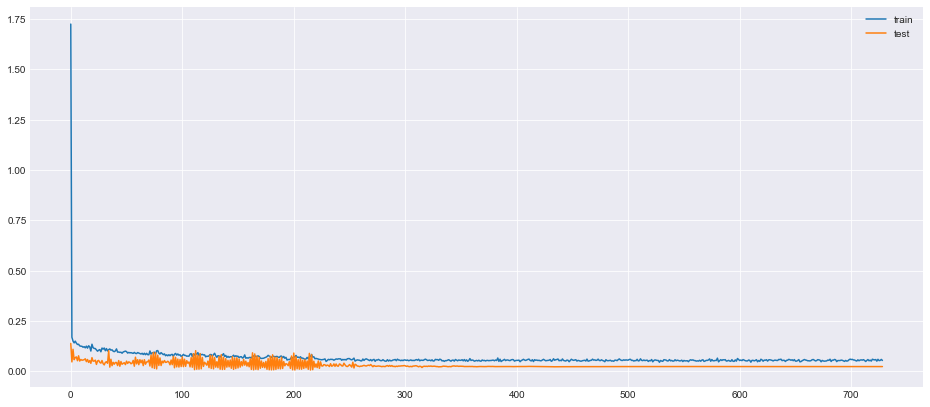

In [79]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [80]:
model_from_saved_checkpoint = load_model('my_best_model_v010.hdf5')

# test test

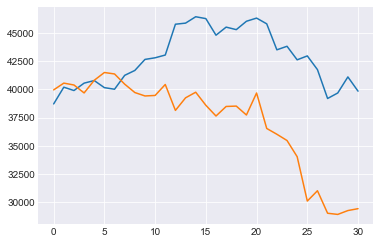

In [81]:
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)

for i in range(len(predicted_btc_price_test_data)):
    predicted_btc_price_test_data[i] = (((predicted_btc_price_test_data[i] * testX[i][0][3]) + 1) * scleR[3])
    testY[i] = (((testY[i] * testX[i][0][3]) + 1) * scleR[3])
    
plt.plot(predicted_btc_price_test_data)
plt.plot(testY)

# test train

In [103]:
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

In [106]:
((predicted_btc_price_train_data[0] * trainX[i][0][3]) + 1)* scleR[3]

array([48079.062], dtype=float32)

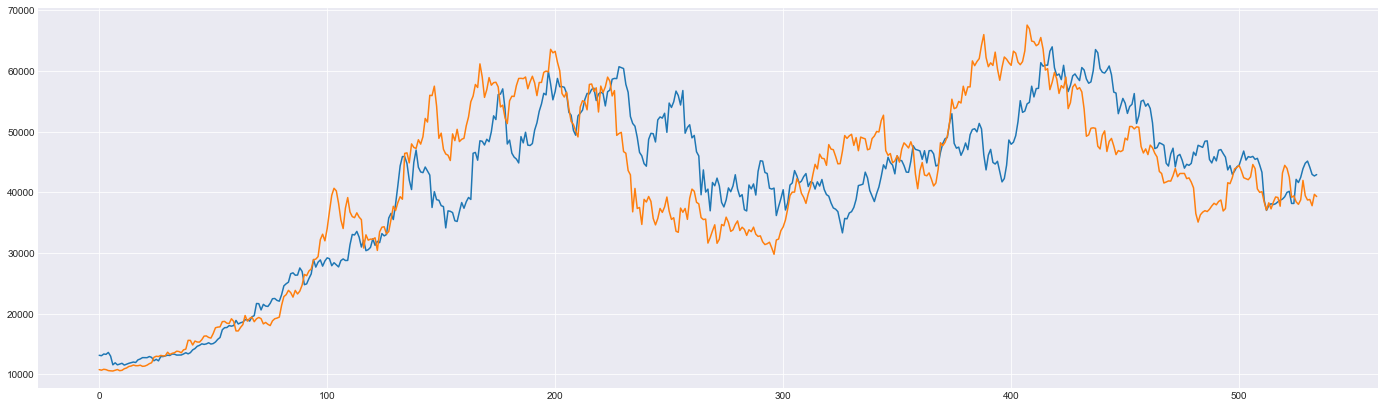

In [109]:
plt.figure(figsize=(24,7))

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

for i in range(len(predicted_btc_price_test_data)):
    predicted_btc_price_train_data[i] = ((predicted_btc_price_train_data[i] * trainX[i][0][3]) + 1)* scleR[3]
#     trainY[i] = (((trainY[i] * trainX[i][0][3]) + 1) * scleR[3])
    
plt.plot(predicted_btc_price_train_data)
plt.plot(trainY)

# future

###### many to one

In [264]:
from collections import deque
SEQ_LEN=len(testX[-1])
prev_days = deque(maxlen=SEQ_LEN)

for i in range(-len(testX[-1]),0,1):
  # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
  prev_days.append(testX[-1][i])

In [265]:
y_p_ = []
future_len = 180
for i in range(future_len):
  x__ = np.array(prev_days).reshape(-1,1).astype(np.float32)

  per = model_from_saved_checkpoint.predict(np.array([x__,x__]))[0].reshape(-1,1)
  prev_days.append(per.reshape(-1,1))
  y_p_.append(per.reshape(-1,1))
  # y_p_.append(scaler.inverse_transform(per.reshape(-1,1)))


In [257]:
# log
y_p_ = scaler_tlog.inverse_transform(np.array(y_p_).reshape(-1, 1))
# manoal
# y_p_ = scaler_t.inverse_transform(np.array(y_p_).reshape(-1, 1))

###### plot future

In [258]:
actual = np.concatenate((train_actual,test_actual))
predicted_btc_price = np.concatenate((predicted_btc_price_train_data, predicted_btc_price_test_data, np.array(y_p_).reshape(-1,1)), axis=0)

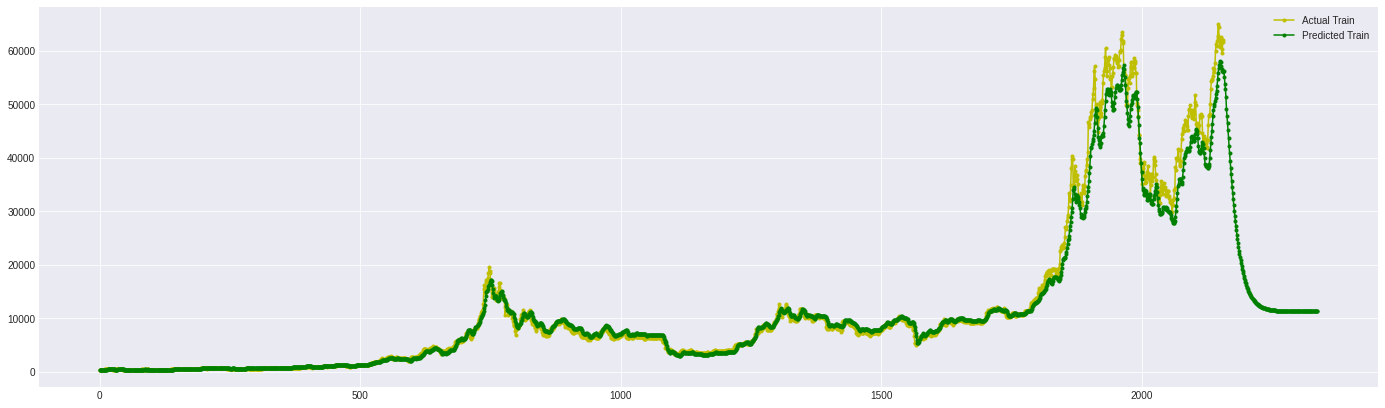

In [268]:
plt.figure(figsize=(24,7))

# log
plt.plot(np.exp(actual),'y', marker='.', label='Actual Train')
plt.plot(np.exp(predicted_btc_price), 'g', marker='.', label='Predicted Train')
# manoal
# plt.plot(actual,'y', marker='.', label='Actual Train')
# plt.plot(predicted_btc_price, 'g', marker='.', label='Predicted Train')


plt.legend()
plt.show()